## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k + C_{i}
\end{equation}

In [1]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
from os import listdir
from natsort                import natsorted

from tqdm   import tqdm
from time   import time

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})
rc('font', family='serif')
rc('text', usetex=True)

### Functions


In [31]:
def g(t, z, args):
    '''
    ODE function of the latent dynamics. 
    '''
    A, B, C = args
    # return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)
    return C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
        


def make_args(n_latent):
    '''
    Initialise tensors A and B for the ODE function.
    '''
    C = torch.randn(n_latent)
    A = torch.randn(n_latent, n_latent)
    B = torch.randn(n_latent, n_latent, n_latent)

    return A,B,C

def make_setup(n_batch, n_latent, dt):
    '''
    Create the correct input torch tensors, given
        - the batch size, n_batch
        - the size of the latent space, n_latent.
    
    Creates randomised latent vector with values between -1 and 1.
    '''

    ## Randomised latent vector
    z0 = torch.rand(n_latent)*2-1

    ## Initial conditions
    t0 = 0.0

    ## End time and time step
    t1 = 1.e0
    # dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    ## Create batches
    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch, dt


def solver(args, atol, rtol, n_batch, n_latent,dt, DEVICE):
    t_eval,z_0,dt = make_setup(n_batch, n_latent,dt)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data, dt


def remove_num_noise(sol, lim):
    w = np.where(np.logical_or(np.abs(sol) > lim,np.isnan(sol)))
    idx = [0]
    for i in range(1,len(w[0])):
        if w[0][i] != w[0][i-1]:
            idx.append(i)

    return w,np.array(idx)

def get_dynamics(sol, lim= 10, plot = False):

    if plot:
        fig, ax1 = plt.subplots(1,1,figsize=(8,4))
        # ax1 = axs[0]
        # ax2 = axs[1]

        a = 0.3

    w,idx = remove_num_noise(sol, lim)
    # print('+++++++++++++++++')
    # print(w, idx)
    # print('+++++++++++++++++')

    dyn = list()

    step = 1
    for n in tqdm(range(0,len(idx), step)):
        i = w[0][idx[n]]
        j = w[1][idx[n]]
        
        z = sol[i][:j]
        z0 = sol[i][0]
        Δz = z - z0
        dyn.append(Δz)

        if plot:
            ax1.plot(Δz, '-', alpha = a, label = i)
            # ax2.plot(z, '-', alpha = a, label = i)

    if plot:
        ax1.set_ylabel('$\\tilde{\\bf\\textit{z}}-\\tilde{\\bf\\textit{z}}_0$')
        # ax1.set_ylabel('$z-z_0$', fontsize = 12)
        # ax2.set_ylabel('$z$')

        ylim = 10.01
        xlim = 1000
        # for ax in axs:
        ax1.set_ylim([-ylim,ylim]) # type: ignore
        ax1.set_xlim([0,xlim])
        ax1.set_xlabel('time fraction', fontsize = 12)
        ax1.grid(True, linestyle = '--', linewidth = 0.2)
        # ax1.set(xticklabels=[])
        ax1.set_xlim([0,xlim]) # type: ignore
        ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])

        fig.tight_layout()
        fig.subplots_adjust(hspace = 0.07)

        print('     >> Plotting...')
        plt.show()

    return idx, dyn

def get_sigma(idx, dyn, dt,cutoff,plot = False):
    
    if plot:
        a = 0.5
        fig, ax1 = plt.subplots(figsize=(8,4))

    sigmas = np.zeros([int(dt**(-1)),len(idx)])
    for i in tqdm(range(len(dyn))):   
        sigma = torch.std(dyn[i], axis = 1)
        # print(i,sigma)
        for j in range(len(sigma)-1):
            # print(j)
            sigmas[j][i] = sigma[j]

        if plot:
            ax1.plot(sigma, '-x', lw = 0.5, markersize = 1, alpha = a)

    h = list()
    for j in range(sigmas.shape[0]):
        h.append(1-(len(np.where(sigmas[j] == 0)[0])/sigmas.shape[1]))
    h= np.array(h)

    stds = list()
    for i in range(len(sigmas)):
        if h[i] >= cutoff:
            mu = np.mean(sigmas[i][sigmas[i] != 0 ])
            stds.append(mu)

    if plot:
        ax1.plot(stds, '-x', lw = 1, markersize = 1.5, color = 'k', label = 'mean $\\sigma$')

        ax1.set_ylabel('$\\sigma$')
        ax1.set_xlim([0,1000]) # type: ignore
        ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])
        ax1.set_xlabel('time faction')
        plt.legend(fontsize = 8)

        print('     >> Plotting...')
        plt.show()

    return sigmas,stds


def dynamics_test(n_latent, n_batch,lim, dt,atol, rtol, cutoff,DEVICE, plot = False):
    print('\n-------------------------')
    print('Input:')
    print('     - n_latent', n_latent)
    print('     - n_batch ', n_batch)
    print('     - atol    ', atol)
    print('     - rtol    ', rtol)

    args = make_args(n_latent)

    print(' >> Solving the ODE...')
    t,sol,dt = solver(args, atol, rtol, n_batch, n_latent, dt, DEVICE)

    print(' >> Getting the latent dynamics...')
    idx, dyn = get_dynamics(sol, lim, plot)
    print(' >> Calculating standard deviations...')
    sigmas, stds = get_sigma(idx, dyn, dt,cutoff,plot)

    return stds

### Set up

In [33]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

# n_latents = [2, 3, 4, 5, 8, 10, 12, 16, 20, 25, 32, 48, 64, 128]
n_latents = [8]
n_batch  = 1000
dt = 1.e-3
cutoff = 0.95


atol = 1.0e-5
rtol = 1.0e-2

plot = True

### Calculating & saving the latent dynamics


-------------------------
Input:
     - n_latent 8
     - n_batch  1000
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


100%|██████████| 982/982 [00:43<00:00, 22.66it/s]
/tmp/ipykernel_15590/2726846265.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])


     >> Plotting...


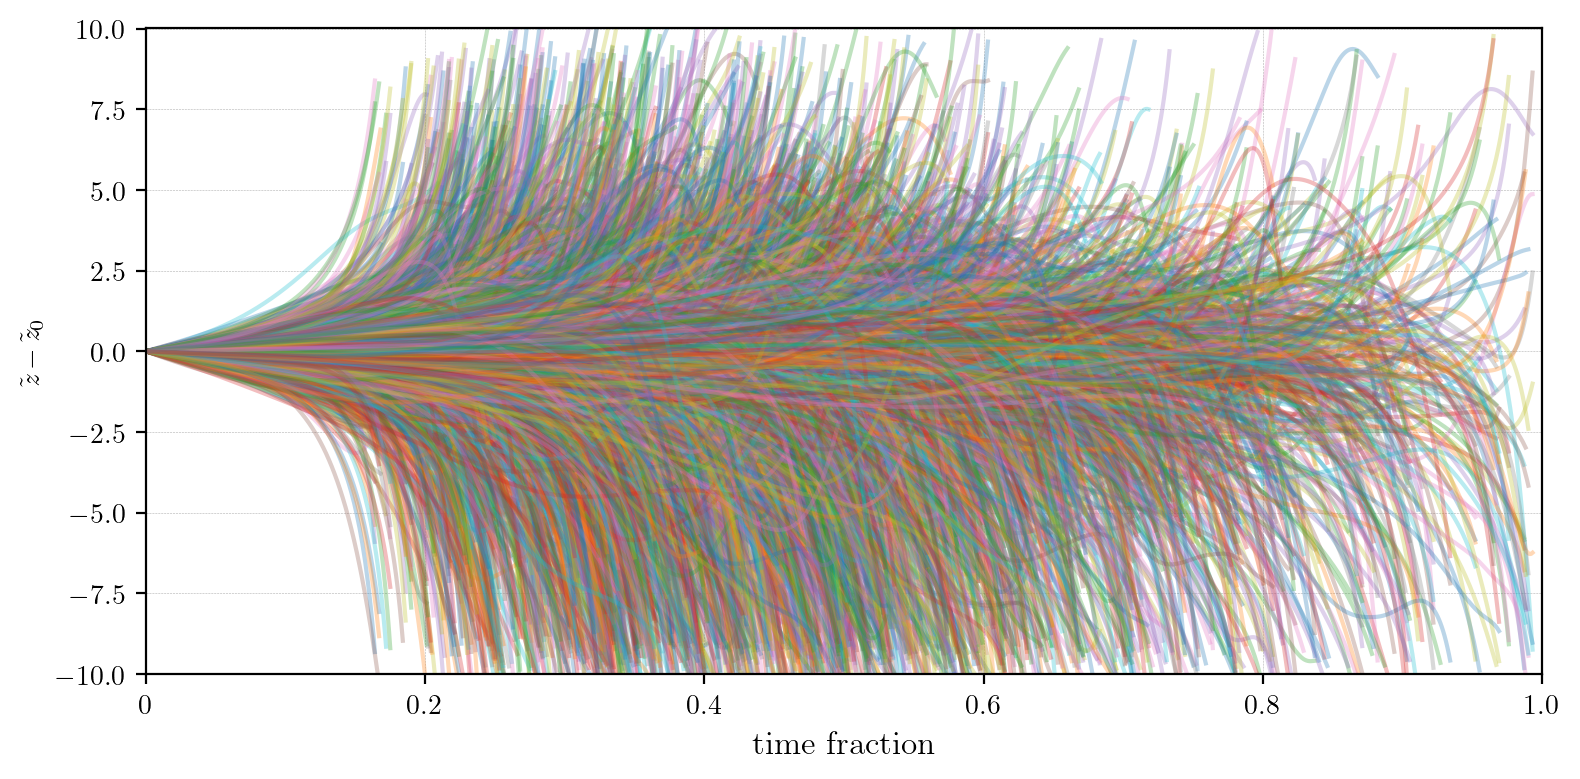

 >> Calculating standard deviations...


100%|██████████| 982/982 [00:09<00:00, 98.22it/s] 
/tmp/ipykernel_15590/2726846265.py:167: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])


     >> Plotting...


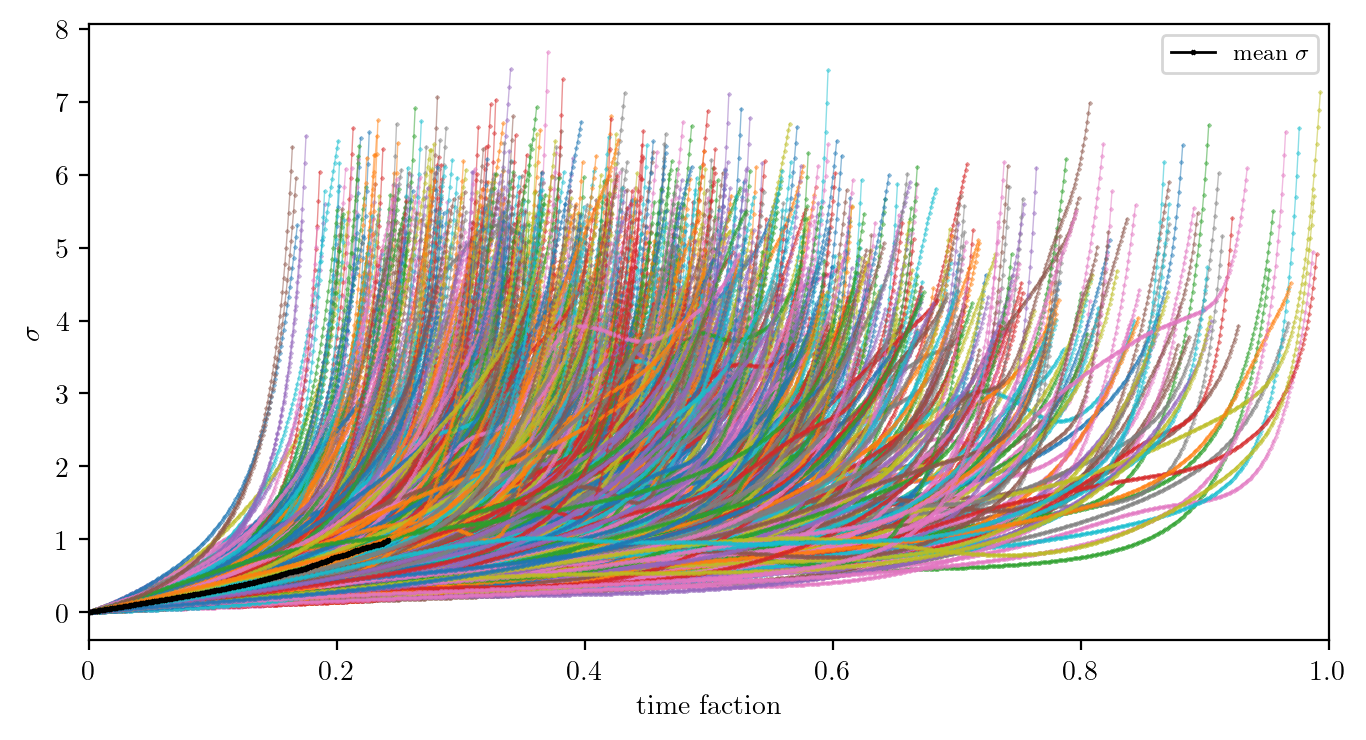


len std 0.242


In [34]:
lim = 10
# i = 2
stds = list()
for i in range(len(n_latents)):
    std = dynamics_test(n_latents[i], n_batch,lim, dt, atol, rtol, cutoff, DEVICE, plot = True)
    print('\nlen std',len(std)*dt)
    stds.append(std)


In [18]:
for i in range(len(stds)):
    np.save('/STER/silkem/MACE/latentdyn/nlatent_'+str(n_latents[i]), stds[i])

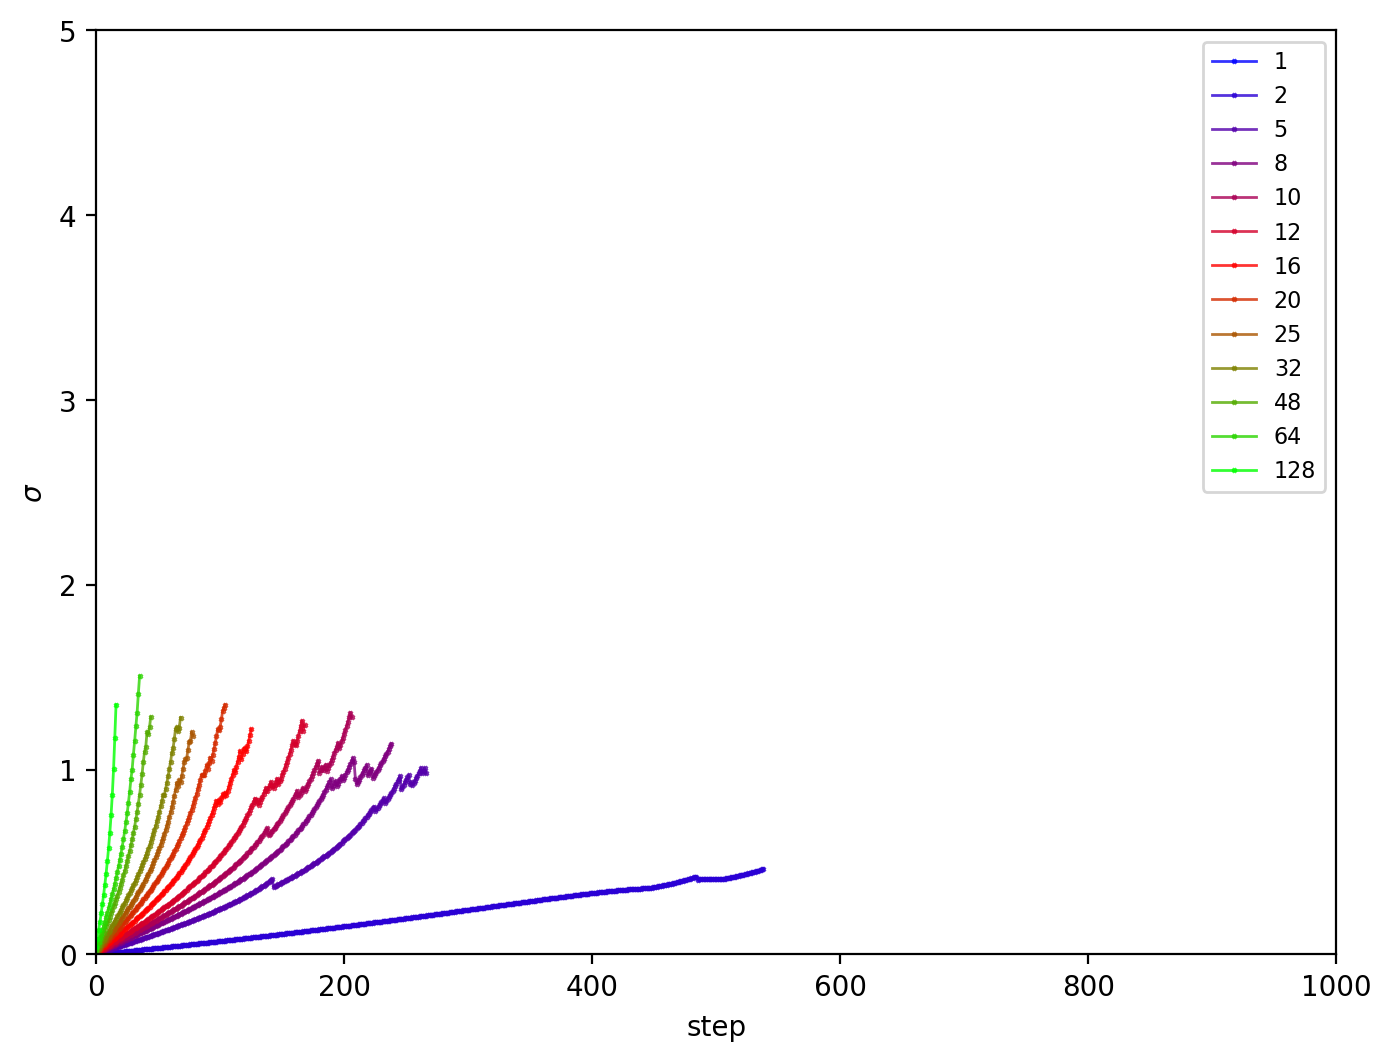

In [98]:
colors = mpl.cm.brg(np.linspace(0, 1, len(n_latents)))

fig, ax1 = plt.subplots(figsize=(8,6))

a = 0.8

for i in range(len(stds)):
    ax1.plot(stds[i], '-x', lw = 1, markersize = 1.5, color = colors[i], label = n_latents[i], alpha = a)

ax1.set_xlim([0,1000])
ax1.set_ylim([0,5])
ax1.set_ylabel('$\\sigma$')
ax1.set_xlabel('step')
plt.legend(fontsize = 8)


plt.show()

## Retrieving the latent dynamics

In [2]:
loc = '/STER/silkem/MACE/latentdyn/'

files = listdir(loc)
files.remove('latent_dynamics.ipynb')
files.remove('first_try')
files.remove('second_try')
files.remove('latent_dyn_tests.py')
files.remove('sigma_dyntest_8.png')
files.remove('z_dyntest.png')
files.remove('z_dyntest_d8.png')
files.remove('z_dyntest_d16.png')
files.remove('all_dyntests.png')
files = natsorted(files)

latent_dyn = dict()
n_latents = list()

for file in files:
    # print(file,file[8:-4])
    n = int(file[8:-4])
    print(n)
    latent_dyn[n] = np.load(loc+file)
    n_latents.append(n)


2
3
4
5
8
10
12
16
20
25
32
48
64
128


In [14]:
for key in latent_dyn.keys():
    print(key, len(latent_dyn[key])/1000)

2 0.969
3 0.258
4 0.296
5 0.269
8 0.221
10 0.175
12 0.146
16 0.117
20 0.09
25 0.078
32 0.062
48 0.043
64 0.033
128 0.017


/tmp/ipykernel_15590/3882120296.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])


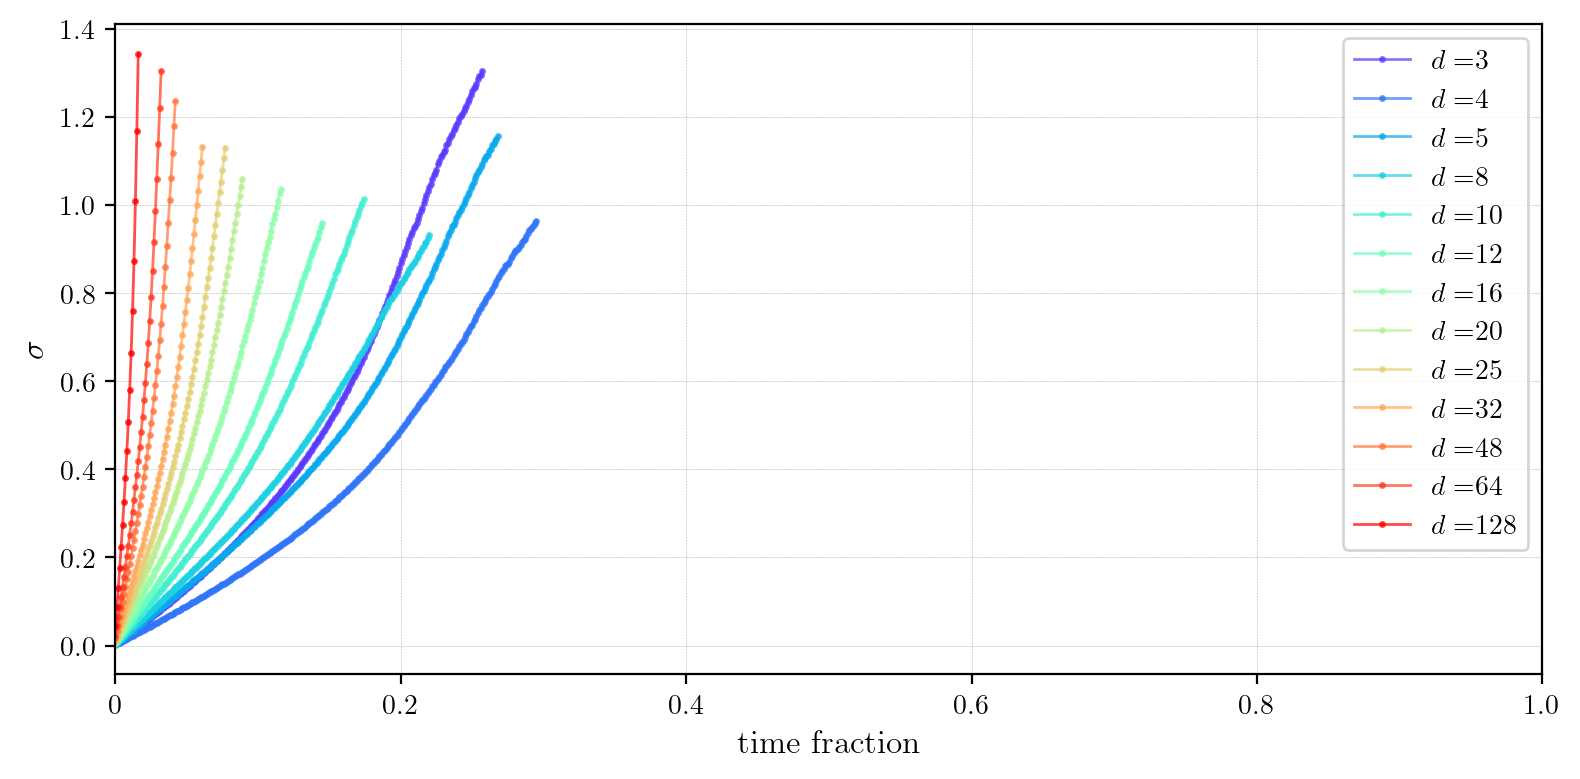

In [3]:
colors = mpl.cm.rainbow(np.linspace(0, 1, len(n_latents)))

fig, ax1 = plt.subplots(figsize=(8,4))

a = 0.7
fs = 12

for i, key in enumerate(latent_dyn):
    # print(str(n_latents[i]))
    # print(i)
    if i != 0  :
        ax1.plot(latent_dyn[key], ls='-',marker = '.', lw = 1, markersize = 3, color = colors[i], label = '$d=$'+str(n_latents[i]), alpha = a)

ax1.grid(True, which='both',linestyle = '--', linewidth = 0.2)
ax1.set_xlim([0,1000]) # type: ignore
ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_ylabel('$\\sigma$', fontsize = fs)
ax1.set_xlabel('${\\rm time\ fraction}$', fontsize = fs)
ax1.legend(fontsize = 10, loc = 'upper right')

fig.tight_layout()

plt.savefig('all_dyntests.png')


plt.show()